## Imports

In [1]:
%matplotlib inline
import os
import cv2
import json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

from components.AttractorLayer import AttractorLayer
from components.RadarLoader import RadarLoader

seq_name = "2020-02-28-13-15-36"
%run carrada_utils/scripts/set_path.py 'components/carrada_datasets/'

## Set Parameters

In [2]:
np.zeros((3*3))

array([0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [3]:
TAU = 1  # TODO: I don't know whether this is important
INTENSITY =1.0
BETA =300  # TODO : Check this
SIGMA = 3.0 # TODO: Check this
SHIFT = 0.0 # TODO : Check this
CUTOFF_DIST = 10 # TODO : Change this
X_EYE = 1.0
Y_EYE = 1.0

K_INHIB = 5.0

In [4]:
data_loader = RadarLoader(seq_name)
data, size_bf = data_loader.get_range_angle_stream_data(clip_and_normalize=True, resize=(64,64))
data_diff_normalized = data_loader.get_range_angle_stream_data_differentiated(clip_and_normalize=True, resize=(64,64))
raw_camera_data = data_loader.get_color_image_datastream(resize=(64,64))

# Load parameters and network

In [5]:
attr_layer = AttractorLayer(
        tau=TAU,
        intensity=INTENSITY,
        cutoff_dist=CUTOFF_DIST,
        sigma=SIGMA,
        shift=SHIFT,
        beta=BETA,
        k=K_INHIB,
        clip=True,
        x_eye=X_EYE,
        y_eye=Y_EYE,
)

attr_layer.set_weights()
attr_layer.save_network(file_path="components/network_weights/threes_win.npy")

#attr_layer.load_network(file_path="components/network_weights/threes_win.npy")

# Run process

In [6]:
neuron_act = []
neuron_act_5 = []
neuron_act_10 = []
for data_entry in data_diff_normalized:
    # Forward pass
    activities_step = attr_layer.forward_pass_visualization(data_entry.flatten(), number_of_passes=4)
    # Get neuron activities
    neuron_act.append(activities_step[0].copy())
    neuron_act_5.append(activities_step[2].copy())
    neuron_act_10.append(activities_step[3].copy())


In [7]:
IO_CUTOFF = 0.4
output_ = []
for i in range(0,len(neuron_act)):
    # Use input and activities to get output
    data_entry_clipped = neuron_act_10[i].copy()
    activities_step_clipped = data_diff_normalized[i].copy()
    #data_entry_clipped[data_entry_clipped < 0.1] = 0.0
    #activities_step_clipped[activities_step_clipped < 0.1] = 0.0
    output_step =  data_entry_clipped * activities_step_clipped
    output_step[output_step < 0.001] = 0.0
    output_step[output_step > 0.0009] = 1.0
    output_.append(output_step.copy())
    

In [8]:
dense_, sparse_, box_, sp_mp_, sp_mp_vis_ = data_loader.visualize_annotations(differentiated=True, size_bf=size_bf)

HERE


In [9]:
neuron_act_10[100]

array([[1.69241700e-36, 3.00051607e-36, 4.06312477e-36, ...,
        4.62524784e-36, 3.62655397e-36, 2.15001598e-36],
       [7.18517110e-36, 1.27297128e-35, 1.72321514e-35, ...,
        1.31260482e-35, 1.04273123e-35, 6.26344740e-36],
       [2.44149530e-35, 4.32539957e-35, 5.86383145e-35, ...,
        2.98442942e-35, 2.39989532e-35, 1.46019515e-35],
       ...,
       [1.08743904e-25, 3.37352257e-25, 8.84860319e-25, ...,
        3.75842837e-24, 1.23363629e-24, 3.97016885e-25],
       [5.84530474e-27, 1.82207678e-26, 4.79559852e-26, ...,
        1.97816171e-25, 6.56738026e-26, 2.12723710e-26],
       [2.34050036e-28, 7.33616398e-28, 1.93795554e-27, ...,
        7.69790737e-27, 2.59092387e-27, 8.45044937e-28]])

In [10]:
ground_truth_annot = []
predicted_location_network = []

difference_in_location = []
it_i = 0
for data_entry in sp_mp_:
    s_ = np.zeros((64,64))
    tt_ = np.zeros((64,64))
    for sub_entry in data_entry:
        s_[sub_entry[0] // 4][sub_entry[1] // 4] = 1
        loc_ = np.argmax(neuron_act_10[it_i])
        tt_[loc_// 64][loc_ %64]= 1
        
        diff_loc_ = np.sqrt(((loc_// 64) - sub_entry[0]//4)**2 + ((loc_ %64) - sub_entry[1]//4)**2)
        
        difference_in_location.append(diff_loc_)
        break
        
    predicted_location_network.append(tt_.copy())    
    ground_truth_annot.append(s_.copy())
    it_i +=1

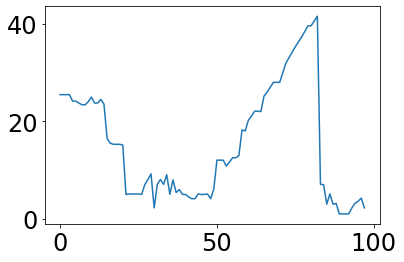

In [11]:
plt.plot(difference_in_location)

# Get annotations and calculate score

In [12]:
CUTOFF = 0.5
mIoU_dense = []
mDice_dense = []
mIoU_sparse = []
mDice_sparse = []
for i in range(0,len(dense_)):
    A_acts = neuron_act[i].copy()
    A_acts[A_acts < 0.1] = 0
    A_acts[A_acts > 0.09] = 1
    B_gt_dense = dense_[i].copy() * 1
    B_gt_sparse = sparse_[i].copy() * 1
     
    A_B_intersection_dense = A_acts.copy()
    A_B_intersection_dense[B_gt_dense == 1.0] = 1.0
    A_B_intersection_dense[B_gt_dense != 1.0] = 0.0
    
    A_B_union_dense = B_gt_dense.copy()
    A_B_union_dense[A_acts > 0] = 1.0
    
    if np.sum(A_B_union_dense) <=0.001:
        continue
    mIoU_dense.append(np.sum(A_B_intersection_dense) / np.sum(A_B_union_dense))
    mDice_dense.append(np.sum(A_B_intersection_dense) * 2 / (np.sum(B_gt_dense) + np.sum(A_acts)))
    
     
    A_B_intersection_sparse = A_acts.copy()
    A_B_intersection_sparse[B_gt_sparse == 1.0] = 1.0
    A_B_intersection_sparse[B_gt_sparse != 1.0] = 0.0
    
    A_B_union_sparse = B_gt_sparse.copy()
    A_B_union_sparse[A_acts > 0] = 1.0
    if np.sum(A_B_union_sparse) <=0.001:
        continue
    mIoU_sparse.append(np.sum(A_B_intersection_sparse) / np.sum(A_B_union_sparse))
    mDice_sparse.append(np.sum(A_B_intersection_sparse) * 2 / (np.sum(B_gt_sparse) + np.sum(A_acts)))
    
    
title_string = f"Losses \n        mIoU_dense: {np.mean(mIoU_dense[40:]):.6f}\n     mIoU_sparse: {np.mean(mIoU_sparse[40:]):.6f}\n"
print(title_string)

Losses 
        mIoU_dense: 0.000000
     mIoU_sparse: 0.000000



In [13]:


fig, (ax1, ax2, ax3, ax4, ax5)= plt.subplots(1, 5, figsize=(18,5), dpi=100)
fig.suptitle(title_string, fontsize=10)

annotated_neuron_act = np.zeros((len(neuron_act), 64,64,3))
annotated_neuron_act[:,:,:,1] = ground_truth_annot 
annotated_neuron_act[:,:,:,2] = predicted_location_network

ax1.tick_params(axis='both',labelsize=8)
ax1.set_title("Neuron Activities with Annotation",fontsize=10)
ax2.tick_params(axis='both',labelsize=8)
ax2.set_title("Neuron Activities",fontsize=10)
ax3.tick_params(axis='both',labelsize=8)
ax3.set_title("Differentiated Input",fontsize=10)
ax4.tick_params(axis='both',labelsize=8)
ax4.set_title("Raw Data Input",fontsize=10)
ax5.tick_params(axis='both',labelsize=8)
ax5.set_title("Raw Camera RGB Data",fontsize=10)

cell_act_map_w_annot = ax1.imshow(annotated_neuron_act[0], cmap='hot', interpolation='none')
cell_act_map = ax2.imshow(np.array(neuron_act[0]), cmap='hot', interpolation='none')
input_diff_map = ax3.imshow(np.array(data_diff_normalized[0]), cmap='hot',interpolation='none')
input_map = ax4.imshow(np.array(data[1]), cmap='hot', interpolation='none')
rgb_cam_data = ax5.imshow(np.array(raw_camera_data[1]), interpolation='none')


def init():
    
    cell_act_map_w_annot.set_data(annotated_neuron_act[0])
    cell_act_map.set_data(np.array(neuron_act[0]))
    input_diff_map.set_data(np.array(data_diff_normalized[0]))
    input_map.set_data(np.array(data[1]))
    rgb_cam_data.set_data(np.array(raw_camera_data[1]))
    return [cell_act_map_w_annot, cell_act_map, input_diff_map, input_map, rgb_cam_data]

# animation function.  This is called sequentially
def animate(i):
    cell_act_map_w_annot.set_data(annotated_neuron_act[i])
#     arr = neuron_act[i]/np.max(neuron_act[i])
#     arr[arr < 0.4] = 0
    cell_act_map.set_data(np.array((neuron_act[i])))
    input_diff_map.set_data(np.array(data_diff_normalized[i]))
    input_map.set_data(np.array(data[i+1]))
    rgb_cam_data.set_data(np.array(raw_camera_data[i+1]))
    return [cell_act_map_w_annot, cell_act_map, input_diff_map, input_map, rgb_cam_data]


anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=200, interval=1, blit=True)

anim.save('animations/final_anim1_sp_cam_pass_10.gif', fps=10)

from IPython.display import Image, display
with open('animations/final_anim1_sp_cam_pass_10.gif','rb') as file:
    display(Image(file.read()))
    
    

fig, (ax1, ax2, ax3, ax4, ax5)= plt.subplots(1, 5, figsize=(18,5), dpi=100)
fig.suptitle(title_string, fontsize=10)

annotated_neuron_act = np.zeros((len(neuron_act_5), 64,64,3))
annotated_neuron_act[:,:,:,1] = ground_truth_annot 
annotated_neuron_act[:,:,:,2] = predicted_location_network

ax1.tick_params(axis='both',labelsize=8)
ax1.set_title("Neuron Activities with Annotation",fontsize=10)
ax2.tick_params(axis='both',labelsize=8)
ax2.set_title("Neuron Activities",fontsize=10)
ax3.tick_params(axis='both',labelsize=8)
ax3.set_title("Differentiated Input",fontsize=10)
ax4.tick_params(axis='both',labelsize=8)
ax4.set_title("Raw Data Input",fontsize=10)
ax5.tick_params(axis='both',labelsize=8)
ax5.set_title("Raw Camera RGB Data",fontsize=10)

cell_act_map_w_annot = ax1.imshow(annotated_neuron_act[0], cmap='hot', interpolation='none')
cell_act_map = ax2.imshow(np.array(neuron_act_5[0]), cmap='hot', interpolation='none')
input_diff_map = ax3.imshow(np.array(data_diff_normalized[0]), cmap='hot',interpolation='none')
input_map = ax4.imshow(np.array(data[1]), cmap='hot', interpolation='none')
rgb_cam_data = ax5.imshow(np.array(raw_camera_data[1]), interpolation='none')


def init():
    
    cell_act_map_w_annot.set_data(annotated_neuron_act[0])
    cell_act_map.set_data(np.array(neuron_act_5[0]))
    input_diff_map.set_data(np.array(data_diff_normalized[0]))
    input_map.set_data(np.array(data[1]))
    rgb_cam_data.set_data(np.array(raw_camera_data[1]))
    return [cell_act_map_w_annot, cell_act_map, input_diff_map, input_map, rgb_cam_data]

# animation function.  This is called sequentially
def animate(i):
    cell_act_map_w_annot.set_data(annotated_neuron_act[i])
#     arr = neuron_act[i]/np.max(neuron_act[i])
#     arr[arr < 0.4] = 0
    cell_act_map.set_data(np.array((neuron_act_5[i])))
    input_diff_map.set_data(np.array(data_diff_normalized[i]))
    input_map.set_data(np.array(data[i+1]))
    rgb_cam_data.set_data(np.array(raw_camera_data[i+1]))
    return [cell_act_map_w_annot, cell_act_map, input_diff_map, input_map, rgb_cam_data]


anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=200, interval=1, blit=True)

anim.save('animations/final_anim1_sp_cam_10_pass_10.gif', fps=10)

from IPython.display import Image, display
with open('animations/final_anim1_sp_cam_10_pass_10.gif','rb') as file:
    display(Image(file.read()))
    



fig, (ax1, ax2, ax3, ax4, ax5)= plt.subplots(1, 5, figsize=(18,5), dpi=100)
fig.suptitle(title_string, fontsize=10)

annotated_neuron_act = np.zeros((len(neuron_act_10), 64,64,3))
annotated_neuron_act[:,:,:,1] = ground_truth_annot 
annotated_neuron_act[:,:,:,2] = predicted_location_network

ax1.tick_params(axis='both',labelsize=8)
ax1.set_title("Neuron Activities with Annotation",fontsize=10)
ax2.tick_params(axis='both',labelsize=8)
ax2.set_title("Neuron Activities",fontsize=10)
ax3.tick_params(axis='both',labelsize=8)
ax3.set_title("Differentiated Input",fontsize=10)
ax4.tick_params(axis='both',labelsize=8)
ax4.set_title("Raw Data Input",fontsize=10)
ax5.tick_params(axis='both',labelsize=8)
ax5.set_title("Raw Camera RGB Data",fontsize=10)

cell_act_map_w_annot = ax1.imshow(annotated_neuron_act[0], cmap='hot', interpolation='none')
cell_act_map = ax2.imshow(np.array(neuron_act_10[0]), cmap='hot', interpolation='none')
input_diff_map = ax3.imshow(np.array(data_diff_normalized[0]), cmap='hot',interpolation='none')
input_map = ax4.imshow(np.array(data[1]), cmap='hot', interpolation='none')
rgb_cam_data = ax5.imshow(np.array(raw_camera_data[1]), interpolation='none')


def init():
    
    cell_act_map_w_annot.set_data(annotated_neuron_act[0])
    cell_act_map.set_data(np.array(neuron_act_10[0]))
    input_diff_map.set_data(np.array(data_diff_normalized[0]))
    input_map.set_data(np.array(data[1]))
    rgb_cam_data.set_data(np.array(raw_camera_data[1]))
    return [cell_act_map_w_annot, cell_act_map, input_diff_map, input_map, rgb_cam_data]

# animation function.  This is called sequentially
def animate(i):
    cell_act_map_w_annot.set_data(annotated_neuron_act[i])
#     arr = neuron_act[i]/np.max(neuron_act[i])
#     arr[arr < 0.4] = 0
    cell_act_map.set_data(np.array((neuron_act_10[i])))
    input_diff_map.set_data(np.array(data_diff_normalized[i]))
    input_map.set_data(np.array(data[i+1]))
    rgb_cam_data.set_data(np.array(raw_camera_data[i+1]))
    return [cell_act_map_w_annot, cell_act_map, input_diff_map, input_map, rgb_cam_data]


anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=200, interval=1, blit=True)

anim.save('animations/final_anim1_sp_cam_5_pass_10.gif', fps=10)

from IPython.display import Image, display
with open('animations/final_anim1_sp_cam_5_pass_10.gif','rb') as file:
    display(Image(file.read()))

MovieWriter ffmpeg unavailable; using Pillow instead.


TypeError: Image data of dtype object cannot be converted to float

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x11aee4af0> (for post_execute):


IndexError: tuple index out of range

IndexError: tuple index out of range

<Figure size 1800x500 with 5 Axes>